In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D,Dropout ,Flatten,Conv2DTranspose, concatenate, BatchNormalization, Activation, Dense,add,GlobalAveragePooling2D

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import prettytable as pt
import pandas as pd
import numpy as np

import itertools
import os
import time

In [2]:
#GPU FOR TRAINGING
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Avaliable{}:".format(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

editor = "郭又萓"
print("Last edit:{}".format(editor))
print("Time:{}".format(time.ctime(time.time())))

#func for ploting multilabel classification is not finished yet

GPUs Avaliable[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]:
Last edit:郭又萓
Time:Thu Oct 20 22:37:15 2022


In [3]:
#Variables and Constant
DATA_TYPE = "MLO"
BATCH_SIZE = 32
IMG_SIZE = (224,224)
DATA_CLASS = ['Benign','Malignant']

model_name = "VGG19"
learning_rate = 0.001
epochs = 30
show_detail = True

csv_path = "C:\\Users\\yui\\history_report.csv"

In [4]:
#define some functions

def join_path(root:str , *params)-> str:
    # give root and folders / files will return a path in str
    temp = root
    for p in params:
        temp = os.path.join(temp,p)
    return temp

#This will plot a binary or multiclass classification's confusion matrix
def plot_confusion_matrix(cm, classes
                          ,normalize = False
                          ,title='Confusion matrix'
                          ,cmap=plt.cm.Blues):
    
    plt.figure(figsize=(6,6))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45,fontsize=12)
    plt.yticks(tick_marks,classes,fontsize=12)
    if normalize :
        cm = cm.astype('float') / cm.sum(axis=1)[:,np/newaxis]
        # print("Normalized confusion matrix")
    else :
        # print("Confusion matrix")
        pass
    # print(cm)
    
    thresh = cm.max() / 2.
    for i , j in itertools.product(range(cm.shape[0]),range(cm.shape[1])): 
        plt.text(j,i,cm[i,j],
                ha = "center",
                fontsize = 15,
                color = "orange" if cm[i,j]> thresh else "purple")
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

def plot_multi_label_confusion_matrix(cm,classes,cmap=plt.cm.Blues) -> None:
    #give the whole ConfusionMatrix and classes and it will plot it out
    fig,ax = plt.subplots(2,int(len(cm)/2))
    count = 0
    for a,b in itertools.product(range(2),range(int(len(cm)/2))):


        thresh = cm[count].max() / 2.
        temp_cm = cm[count]
        class_ = classes[count]

        # plt.figure(figsize=(6,6))
        ax[a][b].imshow(temp_cm,interpolation='nearest',cmap=plt.cm.Blues)
        ax[a][b].set_title(class_)

        if(a == 0 and b==0):
            ax[a][b].set_yticks(np.arange(2),["TrueNegative , FalsePositive","FalseNegative , TruePositive "])
        else:
            ax[a][b].set_yticks([])

        ax[a][b].set_xticks([])
        for i,j in itertools.product(range(len(temp_cm[:][0])),range(len(temp_cm[0][:]))):
                ax[a][b].text(j,i,temp_cm[i][j],
                        ha = "center",
                        color = "orange" if temp_cm[i,j]> thresh else "purple")
        count += 1

def plot_acc_loss(acc,val_acc,loss,val_loss):
    #give values from fit history and it will plot out a graph
    plt.figure(figsize=(8,8))

    plt.subplot(2,1,1)
    plt.plot(acc,label="Trainging Accuracy")
    plt.plot(val_acc,label="Validation Accuracy")
    plt.legend(loc="upper left")
    plt.ylabel("Accuracy")
    plt.ylim([min(plt.ylim()),1])
    plt.title("Training and Validation Accuracy")

    plt.subplot(2,1,2)
    plt.plot(loss,label="Trainging Loss")
    plt.plot(val_loss,label="Validation Loss")
    plt.legend(loc="upper right")
    plt.ylabel("Cross Entropy")
    # plt.ylim([0,1.0]) #too high so let's not use this now
    plt.title("Trainging and Validation Loss")
    plt.xlabel("epoch")
    plt.show()

def plot_imgs(lots_imgs,lots_labels):
    # give 9 imgs and 9 lables,it will plot it out
    imgs = lots_imgs[:9]
    labels = lots_labels[:9]
    
    plt.figure(figsize=(15,15))
    for i in range(len(imgs)):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(imgs[i])
        plt.title(labels[i])
        plt.axis("off")

def convert_cm_to_container(cm):
    #give it a Multilabel Confusion Matrix and it will store it in a str, ez for storing in csv
    cm_container = str()
    if len(cm)==2:
        for i ,j in itertools.product(range(len(cm)),range(2)):
            cm_container += "{}_".format(cm[i,j])
    else:
        for i,j,k in itertools.product(range(len(cm)),range(2),range(2)):
            cm_container += "{}_".format(cm[i,j,k])
    return cm_container

def convert_container_to_cm(cm_container):
    #give it the str generate from function above,will return what it suppose to look like originally
    temp = cm_container.split(sep="_")
    size = int((len(temp)-1)/4)
    # print(size)
    if size == 4 or size == 6:
        c_cm = np.empty((size,2,2))
        count = -1
        for i,j,k in itertools.product(range(size),range(2),range(2)):
            count += 1
            # print(count)
            c_cm[i,j,k] = temp[count]
    elif size == 1:
        c_cm = np.empty((2,2))
        count = -1
        for i,j in itertools.product(range(2),range(2)):
            count += 1
            # print(count)
            c_cm[i,j] = temp[count]
    return c_cm

def convert_list_to_str(list_:list) -> str:
    temp = str()
    for item in list_:
        temp += "{}_".format(item)
    return temp

def convert_str_to_list(str_:str) -> list:
    list_ = list()
    str_ = str_.split(sep='_')
    for item in str_[:-1]:
        list_.append(float(item))
    return list_

def show_report(*nums, show_plot:bool=False):
    #give nums to choose which data to show,CAN give multiplay nums at once
    #if want to print out all history better use for loop with it
    #show_plot will control whether to plot ConfusionMatrix or not
    temp = list()
    history_report = pd.read_csv(csv_path)

    table = pt.PrettyTable()
    table.set_style(pt.DOUBLE_BORDER)
    table.hrules=pt.ALL
    temp.append('index')
    for num in nums:
        temp.append(num)
    table.field_names = temp

    for column in ["Date","Model","Batch_size","epochs","Learning_rate","Training_Report","DATA_TYPE"]:
        temp = []
        temp.append(column)
        for num in nums:
            temp.append(history_report.iloc[num][column])
        table.add_row(temp)
    print(table)

    if show_plot == True:
        for num in nums:
            current_cm = convert_container_to_cm(history_report.iloc[num]['Confusion_Matrix'])
            # print(current_cm)
            if len(current_cm)==6:
                plot_multi_label_confusion_matrix(cm=current_cm,classes=['Benign', 'CC', 'Calc', 'MLO', 'Mass', 'Melignant'])
            elif len(current_cm)==4:
                plot_multi_label_confusion_matrix(cm=current_cm,classes=['Benign', 'Calc', 'Mass', 'Melignant'])
            elif len(current_cm)==2:
                plot_confusion_matrix(cm=current_cm,classes=['Benign','Malignant'])
                
            current_row = history_report.iloc[num]
            if current_row.isnull()['acc']==True:
                print('index:{} have no acuracy data for plotting accuracy.'.format(num))
                continue
            print("index:{}".format(num))
            acc = convert_str_to_list(current_row['acc'])
            val_acc = convert_str_to_list(current_row['val_acc'])
            loss = convert_str_to_list(current_row['loss'])
            val_loss = convert_str_to_list(current_row['val_loss'])
            # print(acc,'\n',val_acc,'\n',loss,'\n',val_loss)
            plot_acc_loss(acc=acc,val_acc=val_acc,loss=loss,val_loss=val_loss)
                
            

In [5]:
#import CBIS-DDSM Cropped image data
cc_path = "D:\\CC_FULLS"
mlo_path = "D:\\MLO_FULLS"

if DATA_TYPE == "CC":
    data_path = cc_path
elif DATA_TYPE == "MLO":
    data_path = mlo_path

train_path = os.path.join(data_path,"train")
valid_path = os.path.join(data_path,"val")

train_dataset = ImageDataGenerator().flow_from_directory(directory=train_path,target_size=IMG_SIZE,color_mode="rgb", \
                                                    classes=DATA_CLASS,batch_size=BATCH_SIZE, shuffle=True)
valid_dataset = ImageDataGenerator().flow_from_directory(directory=valid_path,target_size=IMG_SIZE,color_mode="rgb", \
                                                    classes=DATA_CLASS,batch_size=BATCH_SIZE, shuffle=True)

Found 1314 images belonging to 2 classes.
Found 328 images belonging to 2 classes.


C:\Users\yui\anaconda3\envs\tensorflowenv\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


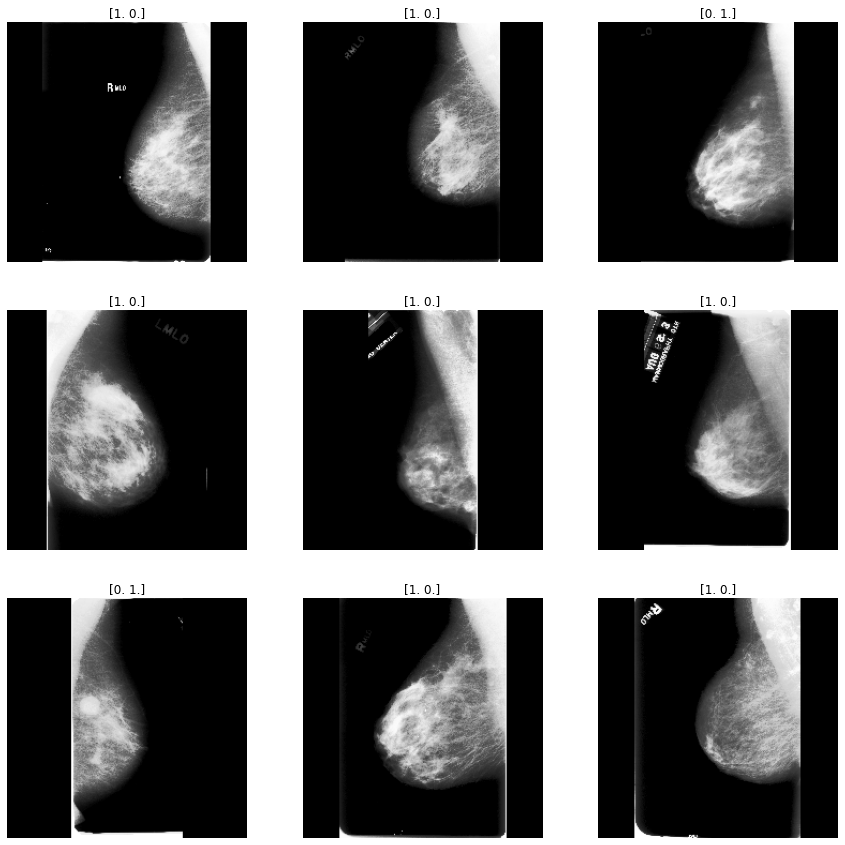

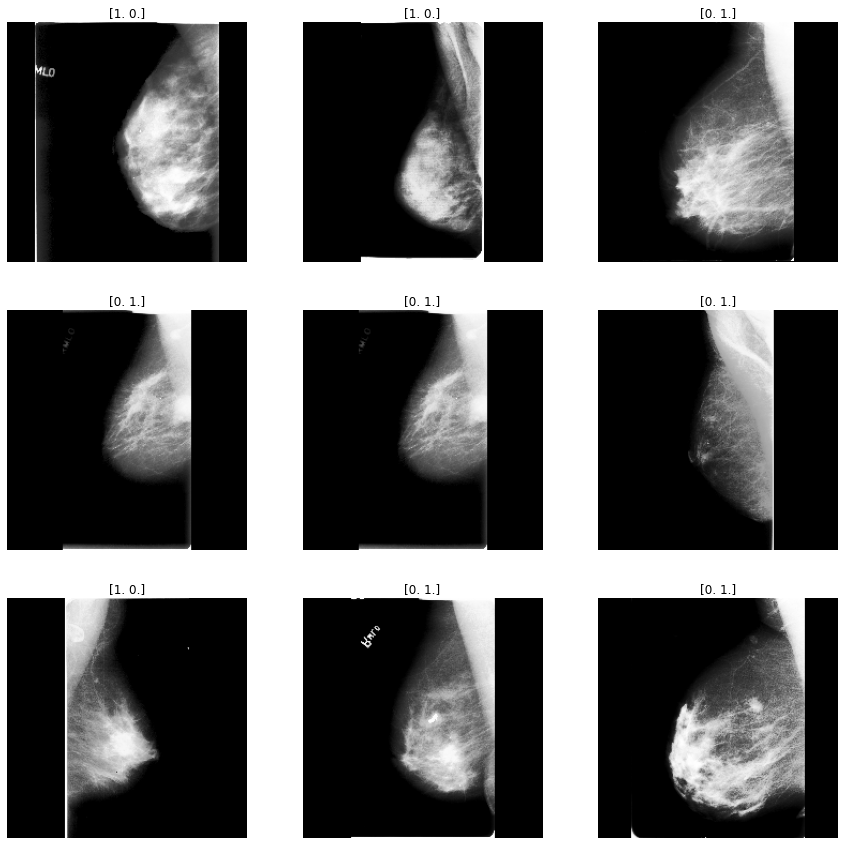

In [6]:
# test if data import correctly

imgs , labels = next(train_dataset)
imgs = imgs/255.
plot_imgs(imgs,labels)

imgs_1,labels_1 = next(valid_dataset)
imgs_1 = imgs_1/255.
plot_imgs(imgs_1,labels_1)

In [7]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
],name="Data_augmentation")

#Rescale Pixel Values
preprocess_input = tf.keras.applications.vgg19.preprocess_input

#VGG19 itself
base_model=VGG19(weights='imagenet',include_top=False)
base_model.trainable = False

# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
flatten_layer = tf.keras.layers.Flatten()

prediction_layer = tf.keras.layers.Dense(len(DATA_CLASS),activation="softmax")

# # Assemble all together
inputs = tf.keras.Input(shape=(IMG_SIZE[0],IMG_SIZE[1],3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x,training=False)
x = flatten_layer(x)
x= Dense(256,activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs,outputs)

if show_detail == True:
    print("VGG19 Model Created.")
    model.summary()

VGG19 Model Created.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten (Flatten)           (None, 2508

In [8]:
# # Show Data Augmentation
# imgs , _ = next(train_dataset)
# imgs = data_augmentation(imgs)
# imgs = imgs/255.
# plot_imgs(imgs,_) 

In [9]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate),loss = tf.keras.losses.binary_crossentropy, metrics=["accuracy"])

In [10]:
loss0,accuracy0 = model.evaluate(valid_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

11/11 [==============================] - 7s 189ms/step - loss: 5.6270 - accuracy: 0.4451
initial loss: 5.63
initial accuracy: 0.45


In [11]:
history = model.fit(x=train_dataset, epochs=epochs, validation_data=valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

Epoch 1/30
42/42 [==============================] - 10s 199ms/step - loss: 0.9498 - accuracy: 0.5868 - val_loss: 1.5309 - val_accuracy: 0.5640
Epoch 2/30
42/42 [==============================] - 8s 186ms/step - loss: 0.7448 - accuracy: 0.6043 - val_loss: 1.1156 - val_accuracy: 0.5610
Epoch 3/30
42/42 [==============================] - 8s 186ms/step - loss: 0.6960 - accuracy: 0.6476 - val_loss: 0.7177 - val_accuracy: 0.5671
Epoch 4/30
42/42 [==============================] - 8s 199ms/step - loss: 0.6642 - accuracy: 0.6469 - val_loss: 0.7440 - val_accuracy: 0.5854
Epoch 5/30
42/42 [==============================] - 8s 199ms/step - loss: 0.6660 - accuracy: 0.6248 - val_loss: 0.7134 - val_accuracy: 0.6037
Epoch 6/30
42/42 [==============================] - 8s 193ms/step - loss: 0.6509 - accuracy: 0.6514 - val_loss: 0.6808 - val_accuracy: 0.6067
Epoch 7/30
42/42 [==============================] - 8s 195ms/step - loss: 0.6601 - accuracy: 0.6499 - val_loss: 0.6574 - val_accuracy: 0.6280
Epoch

In [12]:
predictions = model.predict(valid_dataset)

11/11 [==============================] - 1s 129ms/step


In [13]:
y_pred=np.argmax(predictions,axis=-1)
cm = confusion_matrix(y_true=valid_dataset.classes,y_pred=np.argmax(predictions,axis=-1))
cm_container = convert_cm_to_container(cm)
report = classification_report(y_true=valid_dataset.classes,y_pred=y_pred,target_names=DATA_CLASS)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [14]:
history_report = pd.read_csv(csv_path)
history_report.loc[len(history_report)]=(time.ctime(time.time()),
                                            model_name,
                                            BATCH_SIZE,
                                            epochs,
                                            learning_rate,
                                            report,
                                            cm_container,
                                            convert_list_to_str(acc),
                                            convert_list_to_str(val_acc),
                                            convert_list_to_str(loss),
                                            convert_list_to_str(val_loss),
                                            DATA_TYPE)
history_report.to_csv(csv_path,index=False)

╔═════════════════╦═══════════════════════════════════════════════════════╗
║      index      ║                           -1                          ║
╠═════════════════╬═══════════════════════════════════════════════════════╣
║       Date      ║                Thu Oct 20 22:50:26 2022               ║
╠═════════════════╬═══════════════════════════════════════════════════════╣
║      Model      ║                         VGG19                         ║
╠═════════════════╬═══════════════════════════════════════════════════════╣
║    Batch_size   ║                           32                          ║
╠═════════════════╬═══════════════════════════════════════════════════════╣
║      epochs     ║                           30                          ║
╠═════════════════╬═══════════════════════════════════════════════════════╣
║  Learning_rate  ║                         0.001                         ║
╠═════════════════╬═══════════════════════════════════════════════════════╣
║ Training_R

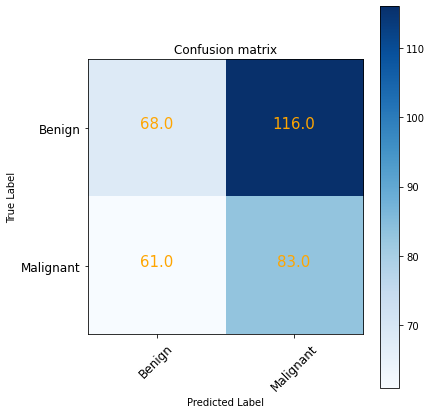

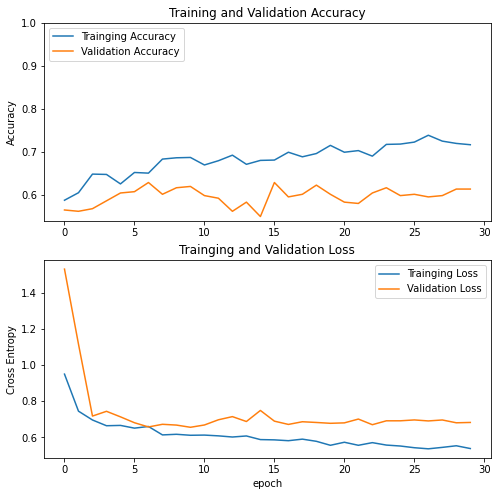

In [15]:
show_report(-1,show_plot=True)

In [23]:
history_report = pd.read_csv(csv_path)

In [43]:
history_report['DATA_TYPE'] = temp

In [50]:
history_report.to_csv(csv_path)

In [24]:
history_report

,Date,Model,Batch_size,epochs,Learning_rate,Training_Report,Confusion_Matrix,acc,val_acc,loss,val_loss,DATA_TYPE
0,Wed Oct 5 22:45:46 2022,MobileNet,32,30,1.000000e-04,precision recall f1-score ...,192_89_132_259_174_178_130_190_304_21_56_291_1...,NaN,NaN,NaN,NaN,NaN
1,Wed Oct 5 23:01:03 2022,MobileNet,32,30,5.000000e-05,precision recall f1-score ...,175_106_99_292_152_200_104_216_281_44_30_317_1...,NaN,NaN,NaN,NaN,NaN
2,Wed Oct 5 23:05:23 2022,MobileNet,32,50,1.000000e-06,precision recall f1-score ...,187_94_109_282_181_171_129_191_287_38_31_316_1...,NaN,NaN,NaN,NaN,NaN
3,Wed Oct 5 23:10:50 2022,MobileNet,32,50,5.000000e-07,precision recall f1-score ...,184_97_104_287_174_178_128_192_286_39_30_317_1...,NaN,NaN,NaN,NaN,NaN
4,Wed Oct 5 23:13:08 2022,MobileNet,32,20,1.000000e-04,precision recall f1-score ...,124_157_63_328_258_67_24_323_323_24_60_265_303...,NaN,NaN,NaN,NaN,NaN
5,Wed Oct 5 23:16:07 2022,MobileNet,32,30,5.000000e-05,precision recall f1-score ...,106_175_50_341_280_45_28_319_311_36_34_291_336...,NaN,NaN,NaN,NaN,NaN
6,Wed Oct 5 23:20:28 2022,MobileNet,32,50,1.000000e-06,precision recall f1-score ...,172_109_107_284_279_46_26_321_319_28_41_284_27...,NaN,NaN,NaN,NaN,NaN
7,Thu Oct 6 13:40:43 2022,MobileNet,32,50,1.000000e-03,precision recall f1-score ...,174_107_122_269_280_45_30_317_317_30_44_281_30...,NaN,NaN,NaN,NaN,NaN
8,Thu Oct 6 13:48:40 2022,MobileNet,32,50,1.000000e-05,precision recall f1-score ...,190_91_128_263_270_55_26_321_319_28_48_277_260...,NaN,NaN,NaN,NaN,NaN
9,Thu Oct 6 14:22:53 2022,MobileNet,32,50,1.000000e-07,precision recall f1-score ...,188_93_125_266_272_53_27_320_319_28_48_277_262...,NaN,NaN,NaN,NaN,NaN


In [38]:
valid_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [39]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,